In [4]:
!pip install tensorflow

In [7]:
import tensorflow as tf

# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [9]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [10]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [11]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [12]:
#values need to be normalized to the range [0,1]

def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

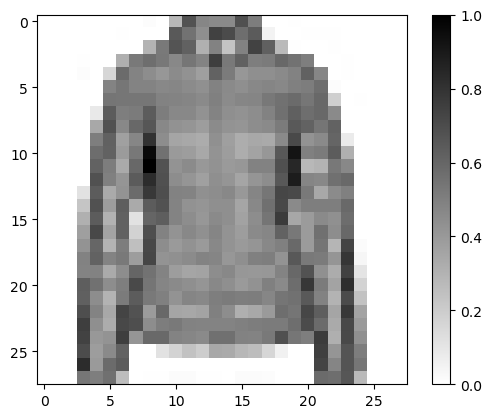

In [13]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

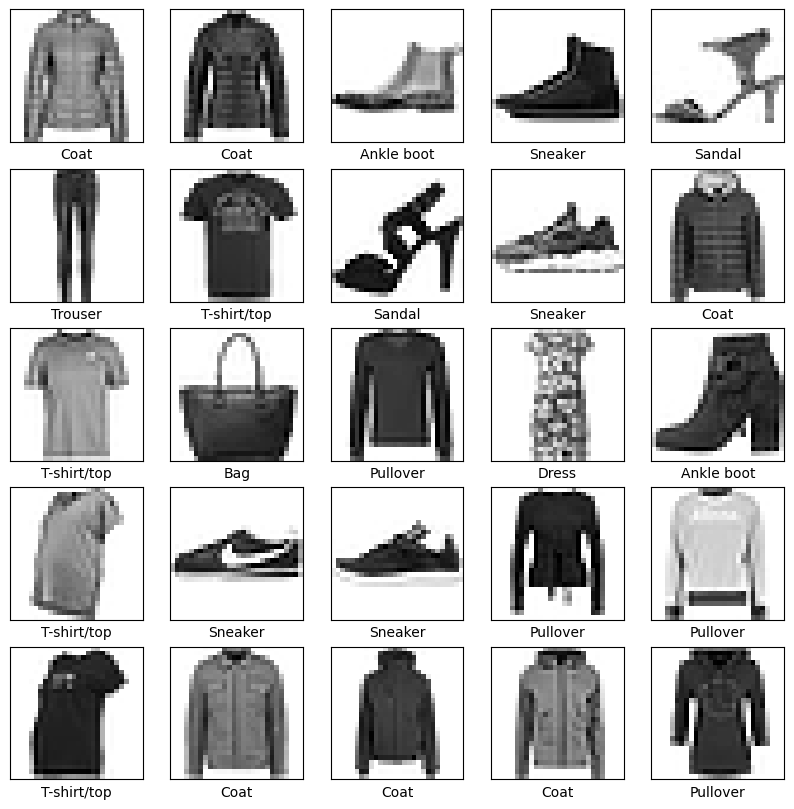

In [15]:
#Display the first 25 images from the training set and display the class name below each image.

plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

In [16]:
#Build the model
#Setup the layers

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [17]:
#Compil the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
#Train the model

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [19]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 33s 15ms/step - loss: 0.3924 - accuracy: 0.8589
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2540 - accuracy: 0.9064
Epoch 3/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2102 - accuracy: 0.9226
Epoch 4/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1799 - accuracy: 0.9337
Epoch 5/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1546 - accuracy: 0.9429
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1304 - accuracy: 0.9518
Epoch 7/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1101 - accuracy: 0.9590
Epoch 8/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0925 - accuracy: 0.9653
Epoch 9/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0775 - accuracy: 0.9713
Epoch 10/10
1875/1875 [==============================] - 28s 15m

In [20]:
#EVALUATION : compare how the model performs on the test dataset

test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 4s 12ms/step - loss: 0.3179 - accuracy: 0.9182
Accuracy on test dataset: 0.9182000160217285


In [21]:
#PREDICTIONS : ith the model trained, we can use it to make predictions about some images.

for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 206ms/step


In [22]:
predictions.shape


(32, 10)

In [33]:
predictions[0]

array([7.2719388e-08, 4.2936612e-08, 3.3900076e-05, 4.4683963e-09,
       6.2508380e-01, 5.7309615e-09, 3.7487823e-01, 1.1446744e-08,
       6.3791838e-09, 3.9878564e-06], dtype=float32)

In [34]:
np.argmax(predictions[0])

4

In [35]:
test_labels[0]

4

In [37]:
#We can graph this to look at the full set of 10 class predictions

def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

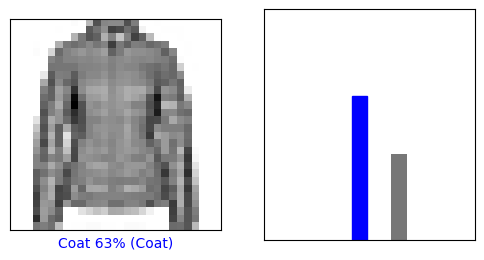

In [39]:
#Let's look at the 0th image, predictions, and prediction array.

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

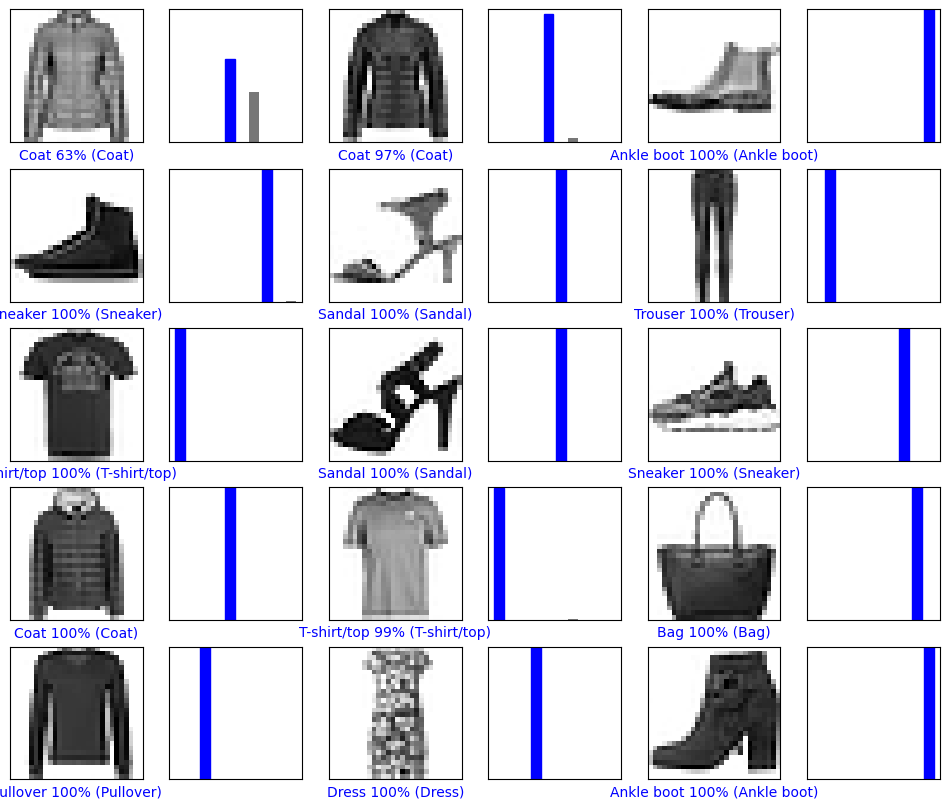

In [40]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [49]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [50]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [51]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 33ms/step
[[7.2719402e-08 4.2936414e-08 3.3900051e-05 4.4684016e-09 6.2508333e-01
  5.7309677e-09 3.7487867e-01 1.1446735e-08 6.3791910e-09 3.9878610e-06]]


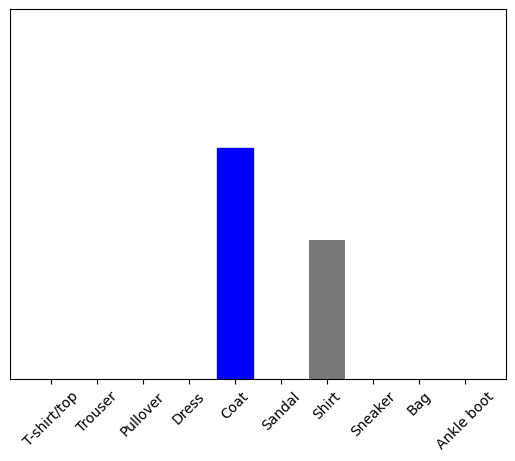

In [52]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [53]:
np.argmax(predictions_single[0])

4